## План работ

 - вынести замену пустых значений по всем количественным переменным в предобработку
 - посмотреть на таблицу корреляции и убрать лишние признаки
 - добавить объяснения взаимосвязи (большую корреляцию признаков)
 - добавить итоговые выводы

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

In [2]:
pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

students = pd.read_csv('stud_math.csv')

In [3]:
students

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2.0,2.0,services,services,course,NaN,1.0,2.0,2.0,no,yes,yes,no,yes,-6.0,yes,no,no,5.0,5.0,4.0,4.0,212.0,45.0
391,MS,M,17,U,LE3,T,3.0,1.0,services,services,course,mother,2.0,1.0,0.0,no,no,no,no,no,-3.0,yes,yes,no,2.0,4.0,5.0,2.0,3.0,80.0
392,MS,M,21,R,GT3,T,1.0,1.0,other,other,course,NaN,1.0,1.0,3.0,NaN,no,no,no,no,-3.0,NaN,no,no,5.0,5.0,3.0,3.0,3.0,35.0
393,MS,M,18,R,LE3,T,3.0,2.0,services,other,course,mother,3.0,1.0,0.0,no,no,no,NaN,no,-3.0,yes,yes,no,4.0,4.0,1.0,5.0,0.0,50.0


## Предобработка

In [4]:
# Функция для вывода информации для номинативных переменных
def column_info(data: pd.DataFrame, column: str) -> None:
    n = 10 # Параметр для оценки наиболее часто встречающихся значений
    print(f'Проведем анализ для переменной {column}')
    
    print('Всего значений:', data.shape[0])
    print('Пустых значений:', data.shape[0] - data[column].notnull().sum())
    print(f'Значений, упомянутых более {n} раз:', (data[column].value_counts() > n).sum())
    print('Уникальных значений:', data[column].nunique())
    
    display(pd.DataFrame(data[column].value_counts()))
    
    data.loc[:,[column]].info()
    

# Функция для вывода информации для колличественных переменных
def plot_column_info(data: pd.DataFrame, column: str) -> None:  
    max_value = data[column].max()
    min_value = data[column].min()
    perc25 = data[column].quantile(0.25)
    perc75 = data[column].quantile(0.75)
    IQR = perc75 - perc25
    lower_limt = perc25 - 1.5*IQR
    upper_limit = perc75 + 1.5*IQR
    
    if max_value <= upper_limit and min_value >= lower_limt:
        outliers_status = 'Выбросов Нет.'
    else:
        outliers_status = 'Есть выбросы.'

    print('Всего значений:', data.shape[0])
    print('Пустых значений:', data.shape[0] - data[column].notnull().sum())
    
    print('25-й перцентиль: {}, 75-й перцентиль: {}, IQR: {},'.format(perc25, perc75, IQR))
    print(f'Границы значений: [{min_value}, {max_value}.')
    print('Границы выбросов: [{f}, {l}],'.format(f=lower_limt, l=upper_limit))
    print(outliers_status)
    
    data[column].loc[data[column].between(lower_limt, upper_limit)].hist(bins=16,
                                                                         range=(min_value, max_value), 
                                                                         label='IQR')

    data[column].hist(alpha=0.5, 
                      bins=16, 
                      range=(min_value, max_value), 
                      label='Исходные значения')

    plt.legend();
    

# Функция для удаления выбросов с помощью IQR. Пустые значения оставляет.
def remove_outliers_iqr(data: pd.DataFrame, column: str) -> pd.DataFrame: 
    perc25 = data[column].quantile(0.25)
    perc75 = data[column].quantile(0.75)
    IQR = perc75 - perc25
    lower_limt = perc25 - 1.5*IQR
    upper_limit = perc75 + 1.5*IQR  
    
    return data.query(f'{lower_limt} <= {column} <= {upper_limit} or {column} != {column}')


# Функция для удаления выбросов исходя из здравого смысла. Пустые значения оставляет.
def remove_outliers_real(data: pd.DataFrame, column: str, lower_limt: float, upper_limit: float) -> pd.DataFrame: 
    
    return data.query(f'{lower_limt} <= {column} <= {upper_limit} or {column} != {column}')


def replace_nan(data: pd.DataFrame, column: str, typ: str):
    ''' 
    Функция производит замену пустых значений признака column в датасете data. 
    Значение на которое делается замены вычислянтся в зависимости от типа typ
    '''
    
    if typ == 'mode':
        m = data.loc[:, column].mode()[0]
        s = 'самым распространенным значением '
    elif typ == 'median':
        m = int(round(data.loc[:, column].median(), 0))
        s = 'медианой'
    elif typ == 'mean':
        m = int(round(data.loc[:, column].mean(), 0))
        s = 'средневзвешенным значением'
    else:
        return None
    
    print(f'Заполним пустые значения признака {s} {m}')
    data.loc[students[column] != students[column], column] = m
    
    
def convert_float_to_int(data: pd.DataFrame, column: str) -> None:
    '''
    Функция проверяет сумму дробных частей значений признака column в датасете data.
    Если сумма нулевая, то можем поменять тип признака с float на int.
    Если нет, то оставляем как есть.
    '''
    
    fl = data.loc[:, column].apply(lambda x: False if x-int(x) == 0 else True).sum() 
    if fl == 0.:
        print(f'Дробной части у значений признака {column} нет. Меняем тип признака на int.')
        data.loc[:, column] = data[column].astype(int)
    else:
        print(f'{fl} значений признака {column} имеют дробную часть. Менять тип признака не имеем права.')

In [5]:
df = pd.DataFrame({'ab': [1., 1.0, 3.0]})
display(df)

convert_float_to_int(df, 'ab')
# students[column].astype(int)

,ab
0,1.0
1,1.0
2,3.0


Дробной части у значений признака ab нет. Меняем тип признака на int.


Для удобства введем два новых списка - наименование номинативных признаков (columns_object) и количественных (columns_int)

In [6]:
columns_object = list(students.select_dtypes(include=['object']).columns)
columns_int =  list(students.select_dtypes(include=['int', 'float']).columns)

В предобработку выносим удаление "лишних" столбцов и устранение выбросов. Но так как это проверочная работа, то в ней будут смотреть не только конечный результат, но и само решение и причины, почему был удален тот или иной выброс. Поэтому код в следующем блоке закомментируем, а преобразование датасета сделаем в ходе решения.

In [7]:
''' 
# Для признака 'Fedu' убираем "лишние" значения
students = students.query('Fedu in [None, 0, 1, 2, 3, 4]')

# Убираем признак 'studytime, granular', так как он линейно зависим от 'studytime'
students.drop(['studytime, granular'], inplace = True, axis = 1)

# Для признака 'famrel' убираем "лишние" значения
students = students.query('famrel in [None, 1, 2, 3, 4, 5]')

# Для признака 'absences' уберем выбросы определенные с помощью IQR
students = remove_outliers_iqr(students, 'absences')

'''

' \n# Для признака \'Fedu\' убираем "лишние" значения\nstudents = students.query(\'Fedu in [None, 0, 1, 2, 3, 4]\')\n\n# Убираем признак \'studytime, granular\', так как он линейно зависим от \'studytime\'\nstudents.drop([\'studytime, granular\'], inplace = True, axis = 1)\n\n# Для признака \'famrel\' убираем "лишние" значения\nstudents = students.query(\'famrel in [None, 1, 2, 3, 4, 5]\')\n\n# Для признака \'absences\' уберем выбросы определенные с помощью IQR\nstudents = remove_outliers_iqr(students, \'absences\')\n\n'

Посмотрим на количество пустых значений наших признаков:

In [8]:
students.isna().sum()

school                  0
sex                     0
age                     0
address                17
famsize                27
Pstatus                45
Medu                    3
Fedu                   24
Mjob                   19
Fjob                   36
reason                 17
guardian               31
traveltime             28
studytime               7
failures               22
schoolsup               9
famsup                 39
paid                   40
activities             14
nursery                16
studytime, granular     7
higher                 20
internet               34
romantic               31
famrel                 27
freetime               11
goout                   8
health                 15
absences               12
score                   6
dtype: int64

Это довольно много для нашего небольшого набора данных (395 строк). Просто удалить их плохо. Попробуем заполнить их исходя из логических рассуждений.

В предобработку выносим замену пустых значений. Но так как это проверочная работа, то в ней будут смотреть не только конечный результат, но и само решение и рассуждения, на какое значение был заменен NaN. Поэтому код в следующем блоке закомментируем, а преобразование датасета сделаем в ходе решения.

In [9]:
'''
# Заполним пустые значения каждого номинативного признака самым часто встречающимся значением этого признака - модой.
for column in columns_object:
    replace_nan(students, column, 'mode')
    
    
    
    
# Поменяем типы количественных признаков на int
column_types = {}
for column in columns_int:
    column_types[column] = int

students.astype(column_types)
'''



"\n# Заполним пустые значения каждого номинативного признака самым часто встречающимся значением этого признака - модой.\nfor column in columns_object:\n    replace_nan(students, column, 'mode')\n    \n    \n    \n    \n# Поменяем типы количественных признаков на int\ncolumn_types = {}\nfor column in columns_int:\n    column_types[column] = int\n\nstudents.astype(column_types)\n"

## Номинативные переменные
### School
school — аббревиатура школы, в которой учится ученик

In [10]:
column = 'school'
column_info(students, column)

Проведем анализ для переменной school
Всего значений: 395
Пустых значений: 0
Значений, упомянутых более 10 раз: 2
Уникальных значений: 2


,school
GP,349
MS,46


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
school    395 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


Пустых значений нет. Значений, требующих дополнительной обработки, тоже нет.

С данной переменной все хорошо. Оставляем как есть.

### Sex
sex — пол ученика ('F' - женский, 'M' - мужской)

In [11]:
column = 'sex'
column_info(students, column)

Проведем анализ для переменной sex
Всего значений: 395
Пустых значений: 0
Значений, упомянутых более 10 раз: 2
Уникальных значений: 2


,sex
F,208
M,187


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
sex    395 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


Пустых значений нет. Значений, требующих дополнительной обработки, тоже нет.

С данной переменной все хорошо. Оставляем как есть.

### Adress
address — тип адреса ученика ('U' - городской, 'R' - за городом)

In [12]:
column = 'address'
column_info(students, column)

Проведем анализ для переменной address
Всего значений: 395
Пустых значений: 17
Значений, упомянутых более 10 раз: 2
Уникальных значений: 2


,address
U,295
R,83


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
address    378 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


Есть 17 пустых значений. Это довольно много для нашего небольшого набора данных. Просто удалить их плохо. Попробуем заполнить их исходя из логических рассуждений.

In [13]:
students.query(f'{column} != {column}')

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
52,GP,M,15,NaN,LE3,A,4.0,2.0,health,NaN,other,father,2.0,1.0,1.0,no,NaN,no,no,yes,-3.0,yes,NaN,no,5.0,5.0,5.0,5.0,6.0,50.0
75,GP,M,15,NaN,GT3,T,4.0,3.0,teacher,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,NaN,NaN,3.0,3.0,5.0,6.0,50.0
92,GP,F,16,NaN,LE3,T,NaN,1.0,other,other,home,father,1.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,3.0,3.0,NaN,2.0,4.0,30.0
96,GP,M,16,NaN,GT3,NaN,4.0,3.0,services,other,reputation,mother,2.0,1.0,0.0,yes,yes,NaN,yes,no,-3.0,NaN,yes,no,3.0,3.0,3.0,4.0,2.0,75.0
159,GP,M,16,NaN,GT3,T,3.0,NaN,other,services,course,father,1.0,2.0,1.0,no,yes,yes,no,yes,-6.0,yes,yes,yes,4.0,5.0,5.0,5.0,4.0,60.0
168,GP,F,16,NaN,GT3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,no,-6.0,yes,yes,no,5.0,1.0,5.0,4.0,0.0,0.0
241,GP,M,17,NaN,LE3,A,4.0,4.0,teacher,other,course,mother,NaN,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,3.0,3.0,NaN,4.0,2.0,60.0
254,GP,M,17,NaN,NaN,T,2.0,1.0,other,other,course,mother,1.0,1.0,0.0,no,no,no,no,no,-3.0,yes,yes,no,4.0,4.0,2.0,5.0,NaN,60.0
270,GP,F,19,NaN,GT3,T,3.0,3.0,other,services,home,other,1.0,2.0,2.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,4.0,3.0,5.0,5.0,NaN,NaN


Исходя из описания, можно предположить, что наш признак address связан с traveltime - время пути от дома до школы. Посторим сводную таблицу для этих признаков.

In [14]:
pivot = students.pivot_table(
    values=['school'],
    index=['address'],
    columns=['traveltime'],
    aggfunc='count',
    fill_value=0
)
display(pivot)

school            
traveltime    1.0 2.0 3.0 4.0
address                      
R              34  26  12   4
U             200  65   9   3

Для значений traveltime = 1 или 2, значение address чаще встречается = U. А для значений traveltime = 3 или 4 чаще встречается R.

Можно было бы заполнить пустые значения нашего признака address исходя из этой закономерности. Но так делать не будем, потому что в таком случае мы повысим взаимозависимость признаков traveltime и address, чего стоит избегать для дальнейшего анализа данных, наряду с тем, как избегаем признаков с высоким коеффициентом корреляции. 

Мы не можем найти среднее арифметическое значений нашего признака, не можем их проранжировать для поиска медианы, но зато мы можем найти самое часто встречающееся — моду. По этой причине заполним пустые значения признака address модой. Также поступим со всеми остальными номинативными признаками.

In [15]:
# Вынесем данное действие в предобработку
replace_nan(students, column, 'mode')

column_info(students, column)

Заполним пустые значения признака самым распространенным значением  U
Проведем анализ для переменной address
Всего значений: 395
Пустых значений: 0
Значений, упомянутых более 10 раз: 2
Уникальных значений: 2


,address
U,312
R,83


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
address    395 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


Значений, требующих дополнительной обработки, нет. Пустых значений нет.

С данной переменной все хорошо. Оставляем как есть.

### Famsize
famsize — размер семьи('LE3' <= 3, 'GT3' >3)

In [16]:
column = 'famsize'
column_info(students, column)

Проведем анализ для переменной famsize
Всего значений: 395
Пустых значений: 27
Значений, упомянутых более 10 раз: 2
Уникальных значений: 2


,famsize
GT3,261
LE3,107


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
famsize    368 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


In [17]:
# Вынесем данное действие в предобработку
replace_nan(students, column, 'mode')

column_info(students, column)

Заполним пустые значения признака самым распространенным значением  GT3
Проведем анализ для переменной famsize
Всего значений: 395
Пустых значений: 0
Значений, упомянутых более 10 раз: 2
Уникальных значений: 2


,famsize
GT3,288
LE3,107


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
famsize    395 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


Значений, требующих дополнительной обработки, нет. Пустых значений нет.

С данной переменной все хорошо. Оставляем как есть.

### Pstatus
Pstatus — статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)

In [18]:
column = 'Pstatus'
column_info(students, column)

Проведем анализ для переменной Pstatus
Всего значений: 395
Пустых значений: 45
Значений, упомянутых более 10 раз: 2
Уникальных значений: 2


,Pstatus
T,314
A,36


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
Pstatus    350 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


In [19]:
# Вынесем данное действие в предобработку
replace_nan(students, column, 'mode')

column_info(students, column)

Заполним пустые значения признака самым распространенным значением  T
Проведем анализ для переменной Pstatus
Всего значений: 395
Пустых значений: 0
Значений, упомянутых более 10 раз: 2
Уникальных значений: 2


,Pstatus
T,359
A,36


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
Pstatus    395 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


Значений, требующих дополнительной обработки, нет. Пустых значений нет.

С данной переменной все хорошо. Оставляем как есть.

### Mjob
Mjob — работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

In [20]:
column = 'Mjob'
column_info(students, column)

Проведем анализ для переменной Mjob
Всего значений: 395
Пустых значений: 19
Значений, упомянутых более 10 раз: 5
Уникальных значений: 5


,Mjob
other,133
services,98
at_home,58
teacher,55
health,32


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
Mjob    376 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


In [21]:
# Вынесем данное действие в предобработку
replace_nan(students, column, 'mode')

column_info(students, column)

Заполним пустые значения признака самым распространенным значением  other
Проведем анализ для переменной Mjob
Всего значений: 395
Пустых значений: 0
Значений, упомянутых более 10 раз: 5
Уникальных значений: 5


,Mjob
other,152
services,98
at_home,58
teacher,55
health,32


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
Mjob    395 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


Значений, требующих дополнительной обработки, нет. Пустых значений нет.

С данной переменной все хорошо. Оставляем как есть.

### Fjob
Fjob— работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

In [22]:
column = 'Fjob'
column_info(students, column)

Проведем анализ для переменной Fjob
Всего значений: 395
Пустых значений: 36
Значений, упомянутых более 10 раз: 5
Уникальных значений: 5


,Fjob
other,197
services,102
teacher,29
at_home,16
health,15


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
Fjob    359 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


In [23]:
# Вынесем данное действие в предобработку
replace_nan(students, column, 'mode')

column_info(students, column)

Заполним пустые значения признака самым распространенным значением  other
Проведем анализ для переменной Fjob
Всего значений: 395
Пустых значений: 0
Значений, упомянутых более 10 раз: 5
Уникальных значений: 5


,Fjob
other,233
services,102
teacher,29
at_home,16
health,15


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
Fjob    395 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


Значений, требующих дополнительной обработки, нет. Пустых значений нет.

С данной переменной все хорошо. Оставляем как есть.

### Reason
reason — причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)

In [24]:
column = 'reason'
column_info(students, column)

Проведем анализ для переменной reason
Всего значений: 395
Пустых значений: 17
Значений, упомянутых более 10 раз: 4
Уникальных значений: 4


,reason
course,137
home,104
reputation,103
other,34


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
reason    378 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


In [25]:
# Вынесем данное действие в предобработку
replace_nan(students, column, 'mode')

column_info(students, column)

Заполним пустые значения признака самым распространенным значением  course
Проведем анализ для переменной reason
Всего значений: 395
Пустых значений: 0
Значений, упомянутых более 10 раз: 4
Уникальных значений: 4


,reason
course,154
home,104
reputation,103
other,34


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
reason    395 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


Значений, требующих дополнительной обработки, нет. Пустых значений нет.

С данной переменной все хорошо. Оставляем как есть.

### Guardian
guardian — опекун ('mother' - мать, 'father' - отец, 'other' - другое)

In [26]:
column = 'guardian'
column_info(students, column)

Проведем анализ для переменной guardian
Всего значений: 395
Пустых значений: 31
Значений, упомянутых более 10 раз: 3
Уникальных значений: 3


,guardian
mother,250
father,86
other,28


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
guardian    364 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


In [27]:
# Вынесем данное действие в предобработку
replace_nan(students, column, 'mode')

column_info(students, column)

Заполним пустые значения признака самым распространенным значением  mother
Проведем анализ для переменной guardian
Всего значений: 395
Пустых значений: 0
Значений, упомянутых более 10 раз: 3
Уникальных значений: 3


,guardian
mother,281
father,86
other,28


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
guardian    395 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


Значений, требующих дополнительной обработки, нет. Пустых значений нет.

С данной переменной все хорошо. Оставляем как есть.

### Schoolsup
schoolsup — дополнительная образовательная поддержка (yes или no)

In [28]:
column = 'schoolsup'
column_info(students, column)

Проведем анализ для переменной schoolsup
Всего значений: 395
Пустых значений: 9
Значений, упомянутых более 10 раз: 2
Уникальных значений: 2


,schoolsup
no,335
yes,51


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
schoolsup    386 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


In [29]:
# Вынесем данное действие в предобработку
replace_nan(students, column, 'mode')

column_info(students, column)

Заполним пустые значения признака самым распространенным значением  no
Проведем анализ для переменной schoolsup
Всего значений: 395
Пустых значений: 0
Значений, упомянутых более 10 раз: 2
Уникальных значений: 2


,schoolsup
no,344
yes,51


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
schoolsup    395 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


Значений, требующих дополнительной обработки, нет. Пустых значений нет.

С данной переменной все хорошо. Оставляем как есть.

### Famsup
famsup — семейная образовательная поддержка (yes или no)

In [30]:
column = 'famsup'
column_info(students, column)

Проведем анализ для переменной famsup
Всего значений: 395
Пустых значений: 39
Значений, упомянутых более 10 раз: 2
Уникальных значений: 2


,famsup
yes,219
no,137


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
famsup    356 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


In [31]:
# Вынесем данное действие в предобработку
replace_nan(students, column, 'mode')

column_info(students, column)

Заполним пустые значения признака самым распространенным значением  yes
Проведем анализ для переменной famsup
Всего значений: 395
Пустых значений: 0
Значений, упомянутых более 10 раз: 2
Уникальных значений: 2


,famsup
yes,258
no,137


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
famsup    395 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


Значений, требующих дополнительной обработки, нет. Пустых значений нет.

С данной переменной все хорошо. Оставляем как есть.

### Paid
paid — дополнительные платные занятия по математике (yes или no)

In [32]:
column = 'paid'
column_info(students, column)

Проведем анализ для переменной paid
Всего значений: 395
Пустых значений: 40
Значений, упомянутых более 10 раз: 2
Уникальных значений: 2


,paid
no,200
yes,155


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
paid    355 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


In [33]:
# Вынесем данное действие в предобработку
replace_nan(students, column, 'mode')

column_info(students, column)

Заполним пустые значения признака самым распространенным значением  no
Проведем анализ для переменной paid
Всего значений: 395
Пустых значений: 0
Значений, упомянутых более 10 раз: 2
Уникальных значений: 2


,paid
no,240
yes,155


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
paid    395 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


Значений, требующих дополнительной обработки, нет. Пустых значений нет.

С данной переменной все хорошо. Оставляем как есть.

### Activities
activities — дополнительные внеучебные занятия (yes или no)

In [34]:
column = 'activities'
column_info(students, column)

Проведем анализ для переменной activities
Всего значений: 395
Пустых значений: 14
Значений, упомянутых более 10 раз: 2
Уникальных значений: 2


,activities
yes,195
no,186


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
activities    381 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


In [35]:
# Вынесем данное действие в предобработку
replace_nan(students, column, 'mode')

column_info(students, column)

Заполним пустые значения признака самым распространенным значением  yes
Проведем анализ для переменной activities
Всего значений: 395
Пустых значений: 0
Значений, упомянутых более 10 раз: 2
Уникальных значений: 2


,activities
yes,209
no,186


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
activities    395 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


Значений, требующих дополнительной обработки, нет. Есть 14 пустых значений.

С данной переменной все хорошо. Оставляем как есть.

### Nursery
nursery — посещал детский сад (yes или no)

In [36]:
column = 'nursery'
column_info(students, column)

Проведем анализ для переменной nursery
Всего значений: 395
Пустых значений: 16
Значений, упомянутых более 10 раз: 2
Уникальных значений: 2


,nursery
yes,300
no,79


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
nursery    379 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


In [37]:
# Вынесем данное действие в предобработку
replace_nan(students, column, 'mode')

column_info(students, column)

Заполним пустые значения признака самым распространенным значением  yes
Проведем анализ для переменной nursery
Всего значений: 395
Пустых значений: 0
Значений, упомянутых более 10 раз: 2
Уникальных значений: 2


,nursery
yes,316
no,79


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
nursery    395 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


Значений, требующих дополнительной обработки, нет. Пустых значений нет.

С данной переменной все хорошо. Оставляем как есть.

### Higher
higher — хочет получить высшее образование (yes или no)

In [38]:
column = 'higher'
column_info(students, column)

Проведем анализ для переменной higher
Всего значений: 395
Пустых значений: 20
Значений, упомянутых более 10 раз: 2
Уникальных значений: 2


,higher
yes,356
no,19


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
higher    375 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


In [39]:
# Вынесем данное действие в предобработку
replace_nan(students, column, 'mode')

column_info(students, column)

Заполним пустые значения признака самым распространенным значением  yes
Проведем анализ для переменной higher
Всего значений: 395
Пустых значений: 0
Значений, упомянутых более 10 раз: 2
Уникальных значений: 2


,higher
yes,376
no,19


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
higher    395 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


Значений, требующих дополнительной обработки, нет. Пустых значений нет.

С данной переменной все хорошо. Оставляем как есть.

### Internet
internet — наличие интернета дома (yes или no)

In [40]:
column = 'internet'
column_info(students, column)

Проведем анализ для переменной internet
Всего значений: 395
Пустых значений: 34
Значений, упомянутых более 10 раз: 2
Уникальных значений: 2


,internet
yes,305
no,56


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
internet    361 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


In [41]:
# Вынесем данное действие в предобработку
replace_nan(students, column, 'mode')

column_info(students, column)

Заполним пустые значения признака самым распространенным значением  yes
Проведем анализ для переменной internet
Всего значений: 395
Пустых значений: 0
Значений, упомянутых более 10 раз: 2
Уникальных значений: 2


,internet
yes,339
no,56


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
internet    395 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


Значений, требующих дополнительной обработки, нет. Пустых значений нет.

С данной переменной все хорошо. Оставляем как есть.

### Romantic
romantic — в романтических отношениях (yes или no)

In [42]:
column = 'romantic'
column_info(students, column)

Проведем анализ для переменной romantic
Всего значений: 395
Пустых значений: 31
Значений, упомянутых более 10 раз: 2
Уникальных значений: 2


,romantic
no,240
yes,124


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
romantic    364 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


In [43]:
# Вынесем данное действие в предобработку
replace_nan(students, column, 'mode')

column_info(students, column)

Заполним пустые значения признака самым распространенным значением  no
Проведем анализ для переменной romantic
Всего значений: 395
Пустых значений: 0
Значений, упомянутых более 10 раз: 2
Уникальных значений: 2


,romantic
no,271
yes,124


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
romantic    395 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


Значений, требующих дополнительной обработки, нет. Пустых значений нет.

С данной переменной все хорошо. Оставляем как есть.

## Колличественные признаки
## Age 
age — возраст ученика (от 15 до 22)

Всего значений: 395
Пустых значений: 0
25-й перцентиль: 16.0, 75-й перцентиль: 18.0, IQR: 2.0,
Границы значений: [15, 22.
Границы выбросов: [13.0, 21.0],
Есть выбросы.


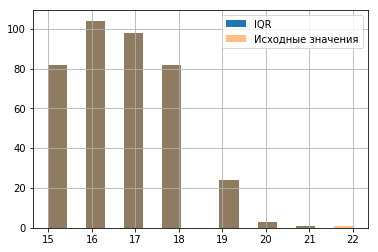

In [44]:
column = 'age'
plot_column_info(students, column)

Верхняя граница выбросов определена как 21, но в описании поля указано, что максимально возможное значение 22. Максимальное значение поля в нашем датасете не превышает 22, значит выбросов нет. 

Пустых значений нет.

In [45]:
# Вынесем данное действие в предобработку
convert_float_to_int(students, column)

Дробной части у значений признака age нет. Меняем тип признака на int.


С данным признаком все хорошо. Оставляем как есть.

### Medu
Medu — образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

Признак может принимать только 5 выше указанных значения. Посмотрим, так ли это и не требуется ли дополнительная обработка.

In [46]:
column = 'Medu'
column_info(students, column)

Проведем анализ для переменной Medu
Всего значений: 395
Пустых значений: 3
Значений, упомянутых более 10 раз: 4
Уникальных значений: 5


,Medu
4.0,131
2.0,102
3.0,97
1.0,59
0.0,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
Medu    392 non-null float64
dtypes: float64(1)
memory usage: 3.2 KB


Значений, требующих дополнительной обработки, нет. Есть 3 пустых значения.

Посмотрим на гистограмму этого признака:

Всего значений: 395
Пустых значений: 3
25-й перцентиль: 2.0, 75-й перцентиль: 4.0, IQR: 2.0,
Границы значений: [0.0, 4.0.
Границы выбросов: [-1.0, 7.0],
Выбросов Нет.


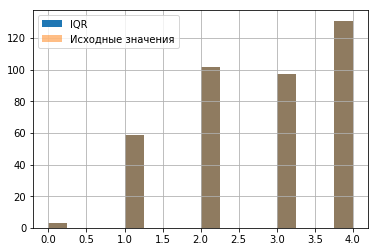

In [47]:
plot_column_info(students, column)

График распределения смещенный влево. Мода будет смещена вправо, а среднее наоборот влево. Типичным наблюдением будем считать медиану.

In [48]:
# Вынесем данное действие в предобработку
replace_nan(students, column, 'median')
convert_float_to_int(students, column)

column_info(students, column)

Заполним пустые значения признака медианой 3
Дробной части у значений признака Medu нет. Меняем тип признака на int.
Проведем анализ для переменной Medu
Всего значений: 395
Пустых значений: 0
Значений, упомянутых более 10 раз: 4
Уникальных значений: 5


,Medu
4,131
2,102
3,100
1,59
0,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
Medu    395 non-null int64
dtypes: int64(1)
memory usage: 3.2 KB


С данным признаком все хорошо. Оставляем как есть.

### Fedu
Fedu — образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

Признак может принимать только 5 выше указанных значения. Посмотрим, так ли это и не требуется ли дополнительная обработка.

In [49]:
column = 'Fedu'
column_info(students, column)

Проведем анализ для переменной Fedu
Всего значений: 395
Пустых значений: 24
Значений, упомянутых более 10 раз: 4
Уникальных значений: 6


,Fedu
2.0,106
3.0,96
4.0,88
1.0,78
0.0,2
40.0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
Fedu    371 non-null float64
dtypes: float64(1)
memory usage: 3.2 KB


Видим, что в одной из записей было указано 40, что явно является некорректно значением для данного признака. Также это значение, скорее всего, будет выбросом, посмотрим:

Всего значений: 395
Пустых значений: 24
25-й перцентиль: 2.0, 75-й перцентиль: 3.0, IQR: 1.0,
Границы значений: [0.0, 40.0.
Границы выбросов: [0.5, 4.5],
Есть выбросы.


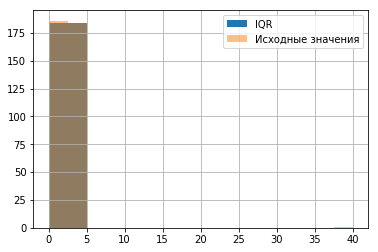

In [50]:
plot_column_info(students, column)

Да, так и есть. Но границы выбросов, рассчитанные с помощью IQR, 0.5 и 4.5. В таком случае 0 - также выброс, но является корректным значением согласно описанию. У нас в датасете есть две записи со значением 0 для рассматриваемого признака. Поэтому отфильтровывать "лишние" записи будем исходя из здравого смысла, т.е. только те записи, признак которых принимает одно из значений 0, 1, 2, 3 и 4. Также оставим записи с пустым значенем. 

In [51]:
# Вынесем данное действие в предобработку.
students = students.query('Fedu in [None, 0, 1, 2, 3, 4]')

Построим гистограмму признака после корректировки:

Всего значений: 394
Пустых значений: 24
25-й перцентиль: 2.0, 75-й перцентиль: 3.0, IQR: 1.0,
Границы значений: [0.0, 4.0.
Границы выбросов: [0.5, 4.5],
Есть выбросы.


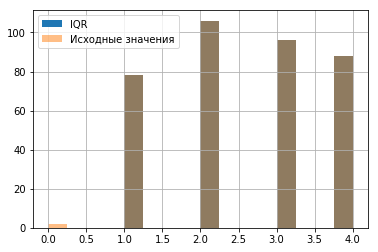

In [52]:
plot_column_info(students, column)

In [53]:
# Вынесем данное действие в предобработку
replace_nan(students, column, 'median')
convert_float_to_int(students, column)

column_info(students, column)

Заполним пустые значения признака медианой 2
Дробной части у значений признака Fedu нет. Меняем тип признака на int.
Проведем анализ для переменной Fedu
Всего значений: 394
Пустых значений: 0
Значений, упомянутых более 10 раз: 4
Уникальных значений: 5


/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Fedu
2,130
3,96
4,88
1,78
0,2


<class 'pandas.core.frame.DataFrame'>
Int64Index: 394 entries, 0 to 394
Data columns (total 1 columns):
Fedu    394 non-null int64
dtypes: int64(1)
memory usage: 6.2 KB


Теперь все хорошо.

### Traveltime
traveltime — время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)

Признак может принимать только 4 выше указанных значения. Посмотрим, так ли это и не требуется ли дополнительная обработка.

In [54]:
column = 'traveltime'
column_info(students, column)

Проведем анализ для переменной traveltime
Всего значений: 394
Пустых значений: 28
Значений, упомянутых более 10 раз: 3
Уникальных значений: 4


,traveltime
1.0,242
2.0,96
3.0,21
4.0,7


<class 'pandas.core.frame.DataFrame'>
Int64Index: 394 entries, 0 to 394
Data columns (total 1 columns):
traveltime    366 non-null float64
dtypes: float64(1)
memory usage: 6.2 KB


Значений, требующих дополнительной обработки, нет. Есть 29 пустых значения.

Посмотрим на гистограмму этого признака:

Всего значений: 394
Пустых значений: 28
25-й перцентиль: 1.0, 75-й перцентиль: 2.0, IQR: 1.0,
Границы значений: [1.0, 4.0.
Границы выбросов: [-0.5, 3.5],
Есть выбросы.


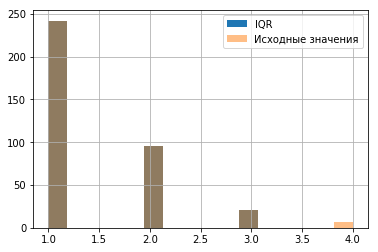

In [55]:
plot_column_info(students, column)

Границы выбросов, рассчитанные с помощью IQR, - [-0.5, 3.5]. В нашем датасете есть записи со значением признака 4, что согласно описанию признака является корректным.

In [56]:
# Вынесем данное действие в предобработку
replace_nan(students, column, 'median')
convert_float_to_int(students, column)

column_info(students, column)

Заполним пустые значения признака медианой 1
Дробной части у значений признака traveltime нет. Меняем тип признака на int.
Проведем анализ для переменной traveltime
Всего значений: 394
Пустых значений: 0
Значений, упомянутых более 10 раз: 3
Уникальных значений: 4


,traveltime
1,270
2,96
3,21
4,7


<class 'pandas.core.frame.DataFrame'>
Int64Index: 394 entries, 0 to 394
Data columns (total 1 columns):
traveltime    394 non-null int64
dtypes: int64(1)
memory usage: 6.2 KB


С данным признаком все хорошо. Оставляем как есть.

### Studytime
studytime — время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)

Признак может принимать только 4 выше указанных значения. Посмотрим, так ли это и не требуется ли дополнительная обработка.

In [57]:
column = 'studytime'
column_info(students, column)

Проведем анализ для переменной studytime
Всего значений: 394
Пустых значений: 7
Значений, упомянутых более 10 раз: 4
Уникальных значений: 4


,studytime
2.0,194
1.0,103
3.0,63
4.0,27


<class 'pandas.core.frame.DataFrame'>
Int64Index: 394 entries, 0 to 394
Data columns (total 1 columns):
studytime    387 non-null float64
dtypes: float64(1)
memory usage: 6.2 KB


Значений, требующих дополнительной обработки, нет. Есть 7 пустых значений.

Посмотрим на гистограмму этого признака:

Всего значений: 394
Пустых значений: 7
25-й перцентиль: 1.0, 75-й перцентиль: 2.0, IQR: 1.0,
Границы значений: [1.0, 4.0.
Границы выбросов: [-0.5, 3.5],
Есть выбросы.


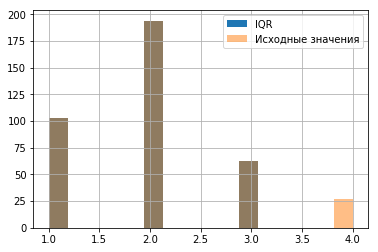

In [58]:
plot_column_info(students, column)

Границы выбросов, рассчитанные с помощью IQR, - [-0.5, 3.5]. В нашем датасете есть записи со значением признака 4, что согласно описанию признака является корректным.

In [59]:
# Вынесем данное действие в предобработку
replace_nan(students, column, 'median')
convert_float_to_int(students, column)

column_info(students, column)

Заполним пустые значения признака медианой 2
Дробной части у значений признака studytime нет. Меняем тип признака на int.
Проведем анализ для переменной studytime
Всего значений: 394
Пустых значений: 0
Значений, упомянутых более 10 раз: 4
Уникальных значений: 4


,studytime
2,201
1,103
3,63
4,27


<class 'pandas.core.frame.DataFrame'>
Int64Index: 394 entries, 0 to 394
Data columns (total 1 columns):
studytime    394 non-null int64
dtypes: int64(1)
memory usage: 6.2 KB


С данным признаком все хорошо. Оставляем как есть.

### Failures
failures — количество внеучебных неудач (n, если 1<=n<=3, иначе 0)

Признак может принимать только 4 выше указанных значения. Посмотрим, так ли это и не требуется ли дополнительная обработка.

In [60]:
column = 'failures'
column_info(students, column)

Проведем анализ для переменной failures
Всего значений: 394
Пустых значений: 22
Значений, упомянутых более 10 раз: 4
Уникальных значений: 4


,failures
0.0,292
1.0,49
2.0,16
3.0,15


<class 'pandas.core.frame.DataFrame'>
Int64Index: 394 entries, 0 to 394
Data columns (total 1 columns):
failures    372 non-null float64
dtypes: float64(1)
memory usage: 6.2 KB


Значений, требующих дополнительной обработки, нет. Есть 22 пустых значений.

Посмотрим на гистограмму этого признака:

Всего значений: 394
Пустых значений: 22
25-й перцентиль: 0.0, 75-й перцентиль: 0.0, IQR: 0.0,
Границы значений: [0.0, 3.0.
Границы выбросов: [0.0, 0.0],
Есть выбросы.


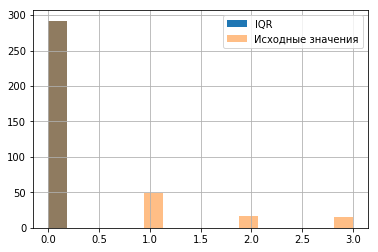

In [61]:
plot_column_info(students, column)

Границы выбросов, рассчитанные с помощью IQR, исключают любое значение кроме ноля. В нашем датасете есть записи со значением признака 1, 2 и 3, что согласно описанию признака является корректным.

In [62]:
# Вынесем данное действие в предобработку
replace_nan(students, column, 'median')
convert_float_to_int(students, column)

column_info(students, column)

Заполним пустые значения признака медианой 0
Дробной части у значений признака failures нет. Меняем тип признака на int.
Проведем анализ для переменной failures
Всего значений: 394
Пустых значений: 0
Значений, упомянутых более 10 раз: 4
Уникальных значений: 4


,failures
0,314
1,49
2,16
3,15


<class 'pandas.core.frame.DataFrame'>
Int64Index: 394 entries, 0 to 394
Data columns (total 1 columns):
failures    394 non-null int64
dtypes: int64(1)
memory usage: 6.2 KB


С данным признаком все хорошо. Оставляем как есть.

### Studytime, granular
Описания данного признака нет. Есть признак со схожим названием - **studytime**. Сравним эти два признака:

In [63]:
students.loc[:, ['studytime', 'studytime, granular']].corr()

,studytime,"studytime, granular"
studytime,1.0,-1.0
"studytime, granular",-1.0,1.0


Эти два признака сильно скоррелированы. Можно предположить, что они линейно зависимы. Попробуем доказать.

Выразим первый элемент из первого признака через первый элемент второго признака.

In [64]:
x = students.loc[1, 'studytime']
y = students.loc[1, 'studytime, granular']
a = - y / x
print(f'{a}*x + y = {a*x + y}')

3.0*x + y = 0.0


Проверим, выражаются ли все остальные значения первого признака через элементы аторго с помощью найденного элемента:

In [65]:
x = students.loc[:, 'studytime']
y = students.loc[:, 'studytime, granular']
(a*x + y).abs().sum()

0.0

Да, так и есть. Таким образом мы получили, что второй признак есть то же самое, что и первый, только выраженный в других величинах. Дополнительной информации для анализа он не несет. Уберем его.

In [66]:
# Вынесем данное действие в предобработку.
students.drop(['studytime, granular'], inplace=True, axis=1)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### Famrel
famrel — семейные отношения (от 1 - очень плохо до 5 - очень хорошо)

Признак может принимать только 5 выше указанных значения. Посмотрим, так ли это и не требуется ли дополнительная обработка.

In [67]:
column = 'famrel'
column_info(students, column)

Проведем анализ для переменной famrel
Всего значений: 394
Пустых значений: 27
Значений, упомянутых более 10 раз: 4
Уникальных значений: 6


,famrel
4.0,182
5.0,98
3.0,62
2.0,17
1.0,7
-1.0,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 394 entries, 0 to 394
Data columns (total 1 columns):
famrel    367 non-null float64
dtypes: float64(1)
memory usage: 16.2 KB


Видим, что в одной из записей было указано -1, что явно является некорректным значением для данного признака. Также это значение, скорее всего, будет выбросом, посмотрим:

Всего значений: 394
Пустых значений: 27
25-й перцентиль: 4.0, 75-й перцентиль: 5.0, IQR: 1.0,
Границы значений: [-1.0, 5.0.
Границы выбросов: [2.5, 6.5],
Есть выбросы.


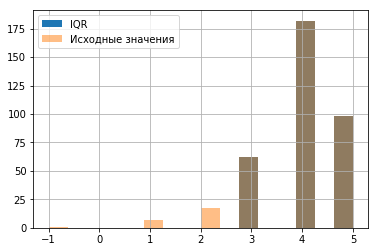

In [68]:
plot_column_info(students, column)

Да, так и есть. Но границы выбросов, рассчитанные с помощью IQR, [2.5 и 6.5]. В таком случае 1 и 2 - также выбросы, но являются корректным значением согласно описанию. У нас в датасете есть записи со значением 1 и 2 для рассматриваемого признака. Поэтому отфильтровывать "лишние" записи будем исходя из здравого смысла, т.е. только те записи, признак которых принимает одно из значений 1, 2, 3, 4 и 5. Также оставим записи с пустым значенем.

In [69]:
# Вынесем данное действие в предобработку.
students = students.query('famrel in [None, 1, 2, 3, 4, 5]')

Построим гистограммцу признака после корректировки:

Всего значений: 393
Пустых значений: 27
25-й перцентиль: 4.0, 75-й перцентиль: 5.0, IQR: 1.0,
Границы значений: [1.0, 5.0.
Границы выбросов: [2.5, 6.5],
Есть выбросы.


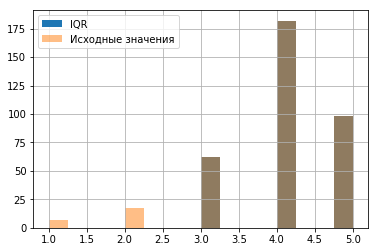

In [70]:
plot_column_info(students, column)

In [71]:
# Вынесем данное действие в предобработку
replace_nan(students, column, 'median')
convert_float_to_int(students, column)

column_info(students, column)

Заполним пустые значения признака медианой 4
Дробной части у значений признака famrel нет. Меняем тип признака на int.
Проведем анализ для переменной famrel
Всего значений: 393
Пустых значений: 0
Значений, упомянутых более 10 раз: 4
Уникальных значений: 5


,famrel
4,209
5,98
3,62
2,17
1,7


<class 'pandas.core.frame.DataFrame'>
Int64Index: 393 entries, 0 to 394
Data columns (total 1 columns):
famrel    393 non-null int64
dtypes: int64(1)
memory usage: 6.1 KB


Значения признака в нужном диапазоне - указанном в описании. Теперь все хорошо.

### Freetime
freetime — свободное время после школы (от 1 - очень мало до 5 - очень мого)

Признак может принимать только 5 выше указанных значения. Посмотрим, так ли это и не требуется ли дополнительная обработка.

In [72]:
column = 'freetime'
column_info(students, column)

Проведем анализ для переменной freetime
Всего значений: 393
Пустых значений: 11
Значений, упомянутых более 10 раз: 5
Уникальных значений: 5


,freetime
3.0,153
4.0,112
2.0,61
5.0,38
1.0,18


<class 'pandas.core.frame.DataFrame'>
Int64Index: 393 entries, 0 to 394
Data columns (total 1 columns):
freetime    382 non-null float64
dtypes: float64(1)
memory usage: 6.1 KB


Значений, требующих дополнительной обработки, нет. Есть 11 пустых значений.

Посмотрим на гистограмму этого признака:

Всего значений: 393
Пустых значений: 11
25-й перцентиль: 3.0, 75-й перцентиль: 4.0, IQR: 1.0,
Границы значений: [1.0, 5.0.
Границы выбросов: [1.5, 5.5],
Есть выбросы.


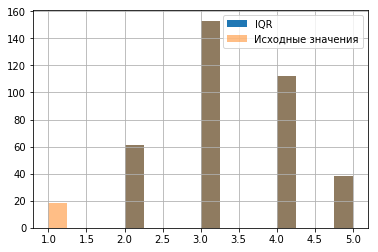

In [73]:
plot_column_info(students, column)

Границы выбросов, рассчитанные с помощью IQR, - [1.5, 5.5]. В нашем датасете есть записи со значением признака 1, что согласно описанию признака является корректным.

In [74]:
# Вынесем данное действие в предобработку
replace_nan(students, column, 'median')
convert_float_to_int(students, column)

column_info(students, column)

Заполним пустые значения признака медианой 3
Дробной части у значений признака freetime нет. Меняем тип признака на int.
Проведем анализ для переменной freetime
Всего значений: 393
Пустых значений: 0
Значений, упомянутых более 10 раз: 5
Уникальных значений: 5


,freetime
3,164
4,112
2,61
5,38
1,18


<class 'pandas.core.frame.DataFrame'>
Int64Index: 393 entries, 0 to 394
Data columns (total 1 columns):
freetime    393 non-null int64
dtypes: int64(1)
memory usage: 6.1 KB


С данным признаком все хорошо. Оставляем как есть.

### Goout
goout — проведение времени с друзьями (от 1 - очень мало до 5 - очень много)

Признак может принимать только 5 выше указанных значения. Посмотрим, так ли это и не требуется ли дополнительная обработка.

In [75]:
column = 'goout'
column_info(students, column)

Проведем анализ для переменной goout
Всего значений: 393
Пустых значений: 8
Значений, упомянутых более 10 раз: 5
Уникальных значений: 5


,goout
3.0,127
2.0,99
4.0,84
5.0,52
1.0,23


<class 'pandas.core.frame.DataFrame'>
Int64Index: 393 entries, 0 to 394
Data columns (total 1 columns):
goout    385 non-null float64
dtypes: float64(1)
memory usage: 6.1 KB


Значений, требующих дополнительной обработки, нет. Есть 8 пустых значений.

Посмотрим на гистограмму этого признака:

Всего значений: 393
Пустых значений: 8
25-й перцентиль: 2.0, 75-й перцентиль: 4.0, IQR: 2.0,
Границы значений: [1.0, 5.0.
Границы выбросов: [-1.0, 7.0],
Выбросов Нет.


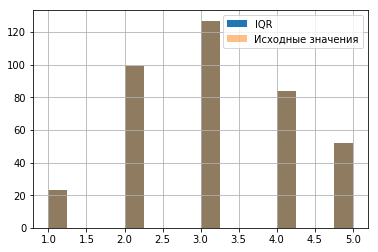

In [76]:
plot_column_info(students, column)

In [77]:
# Вынесем данное действие в предобработку
replace_nan(students, column, 'median')
convert_float_to_int(students, column)

column_info(students, column)

Заполним пустые значения признака медианой 3
Дробной части у значений признака goout нет. Меняем тип признака на int.
Проведем анализ для переменной goout
Всего значений: 393
Пустых значений: 0
Значений, упомянутых более 10 раз: 5
Уникальных значений: 5


,goout
3,135
2,99
4,84
5,52
1,23


<class 'pandas.core.frame.DataFrame'>
Int64Index: 393 entries, 0 to 394
Data columns (total 1 columns):
goout    393 non-null int64
dtypes: int64(1)
memory usage: 6.1 KB


С данным признаком все хорошо. Оставляем как есть.

### Health
health — текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)

Признак может принимать только 5 выше указанных значения. Посмотрим, так ли это и не требуется ли дополнительная обработка.

In [78]:
column = 'health'
column_info(students, column)

Проведем анализ для переменной health
Всего значений: 393
Пустых значений: 15
Значений, упомянутых более 10 раз: 5
Уникальных значений: 5


,health
5.0,137
3.0,89
4.0,62
1.0,47
2.0,43


<class 'pandas.core.frame.DataFrame'>
Int64Index: 393 entries, 0 to 394
Data columns (total 1 columns):
health    378 non-null float64
dtypes: float64(1)
memory usage: 6.1 KB


Значений, требующих дополнительной обработки, нет. Есть 15 пустых значений.

Посмотрим на гистограмму этого признака:

Всего значений: 393
Пустых значений: 15
25-й перцентиль: 3.0, 75-й перцентиль: 5.0, IQR: 2.0,
Границы значений: [1.0, 5.0.
Границы выбросов: [0.0, 8.0],
Выбросов Нет.


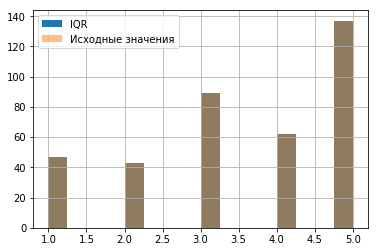

In [79]:
plot_column_info(students, column)

In [80]:
# Вынесем данное действие в предобработку
replace_nan(students, column, 'median')
convert_float_to_int(students, column)

column_info(students, column)

Заполним пустые значения признака медианой 4
Дробной части у значений признака health нет. Меняем тип признака на int.
Проведем анализ для переменной health
Всего значений: 393
Пустых значений: 0
Значений, упомянутых более 10 раз: 5
Уникальных значений: 5


,health
5,137
3,89
4,77
1,47
2,43


<class 'pandas.core.frame.DataFrame'>
Int64Index: 393 entries, 0 to 394
Data columns (total 1 columns):
health    393 non-null int64
dtypes: int64(1)
memory usage: 6.1 KB


С данным признаком все хорошо. Оставляем как есть.

### Absences
absences — количество пропущенных занятий

Всего значений: 393
Пустых значений: 12
25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0,
Границы значений: [0.0, 385.0.
Границы выбросов: [-12.0, 20.0],
Есть выбросы.


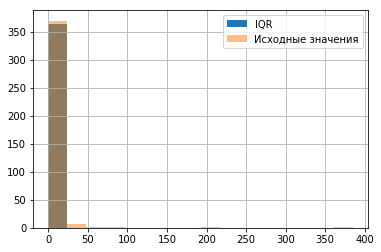

In [81]:
column = 'absences'
plot_column_info(students, column)

У данного признака присутствуют выбросы определенные с помощью IQR. Уберем их:

In [82]:
# Вынесем данное действие в предобработку
students = remove_outliers_iqr(students, column)

Постороим гистограмму признака после корректировки:

Всего значений: 376
Пустых значений: 12
25-й перцентиль: 0.0, 75-й перцентиль: 7.0, IQR: 7.0,
Границы значений: [0.0, 20.0.
Границы выбросов: [-10.5, 17.5],
Есть выбросы.


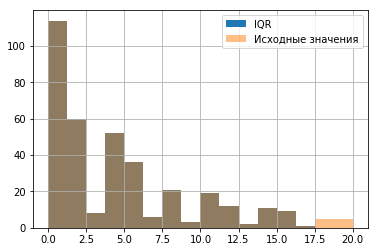

In [83]:
plot_column_info(students, column)

In [84]:
# Вынесем данное действие в предобработку
replace_nan(students, column, 'median')
convert_float_to_int(students, column)

Заполним пустые значения признака медианой 4
Дробной части у значений признака absences нет. Меняем тип признака на int.


Выбросы для заново рассчитанного IQR все еще присутствуют. Оставим как есть.

### Score
score — баллы по госэкзамену по математике

Всего значений: 376
Пустых значений: 6
25-й перцентиль: 40.0, 75-й перцентиль: 70.0, IQR: 30.0,
Границы значений: [0.0, 100.0.
Границы выбросов: [-5.0, 115.0],
Выбросов Нет.


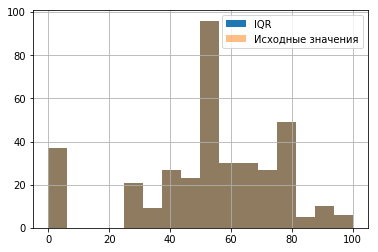

In [85]:
column = 'score'
plot_column_info(students, column)

Есть 6 пустых значения. Заполнять их также как мы делали ранее нельзя, так как суть проекта — отследить влияние условий жизни учащихся (наши признаки) на их успеваемость по математике, критерием которой является баллы по госэкзамену по математике. 

Поэтому нам придется убрать сроки, у которых score пуст.

Дробной части у значений признака score нет. Меняем тип признака на int.
Всего значений: 370
Пустых значений: 0
25-й перцентиль: 40.0, 75-й перцентиль: 70.0, IQR: 30.0,
Границы значений: [0, 100.
Границы выбросов: [-5.0, 115.0],
Выбросов Нет.


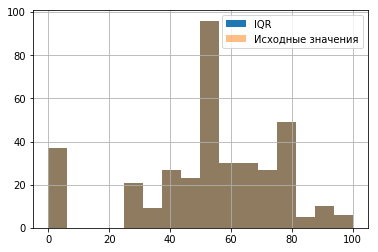

In [86]:
# Вынесем данное действие в предобработку
students = students.query(f'{column} == {column}')

convert_float_to_int(students, column)

plot_column_info(students, column)

С данным признаком все хорошо. Оставляем как есть.

---

## Корреляционный анализ количественных переменных

Выясним, какие столбцы коррелируют с количеством баллов на госэкзамене. Это поможет понять, какие параметры стоит оставить для модели, а какие — исключить. 

Корреляции рассмотрим только для числовых столбцов.

Для быстрого построения графиков зависимости переменных можно воспользоваться функцией pairplot из модуля seaborn:

In [87]:
correlation = students.corr()
correlation

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score
age,1.000000,-0.167349,-0.158911,0.085935,-0.011045,0.197141,0.051423,0.031089,0.131667,-0.060930,0.156966,-0.163148
Medu,-0.167349,1.000000,0.594747,-0.162468,0.098584,-0.247746,-0.006899,0.053127,0.058395,-0.048616,0.069634,0.216701
Fedu,-0.158911,0.594747,1.000000,-0.118942,0.013113,-0.278609,-0.018819,-0.008475,0.046939,0.004679,-0.025769,0.120536
traveltime,0.085935,-0.162468,-0.118942,1.000000,-0.095686,0.048956,-0.040696,0.000211,0.044527,-0.035544,-0.035294,-0.057702
studytime,-0.011045,0.098584,0.013113,-0.095686,1.000000,-0.170281,0.021310,-0.135468,-0.042382,-0.076727,-0.067822,0.116674
failures,0.197141,-0.247746,-0.278609,0.048956,-0.170281,1.000000,-0.007498,0.081502,0.090758,0.089310,0.067235,-0.340175
famrel,0.051423,-0.006899,-0.018819,-0.040696,0.021310,-0.007498,1.000000,0.160022,0.061918,0.091292,-0.069358,0.059558
freetime,0.031089,0.053127,-0.008475,0.000211,-0.135468,0.081502,0.160022,1.000000,0.276457,0.061142,0.096608,0.038314
goout,0.131667,0.058395,0.046939,0.044527,-0.042382,0.090758,0.061918,0.276457,1.000000,-0.003049,0.113919,-0.111028
health,-0.060930,-0.048616,0.004679,-0.035544,-0.076727,0.089310,0.091292,0.061142,-0.003049,1.000000,-0.019518,-0.073805


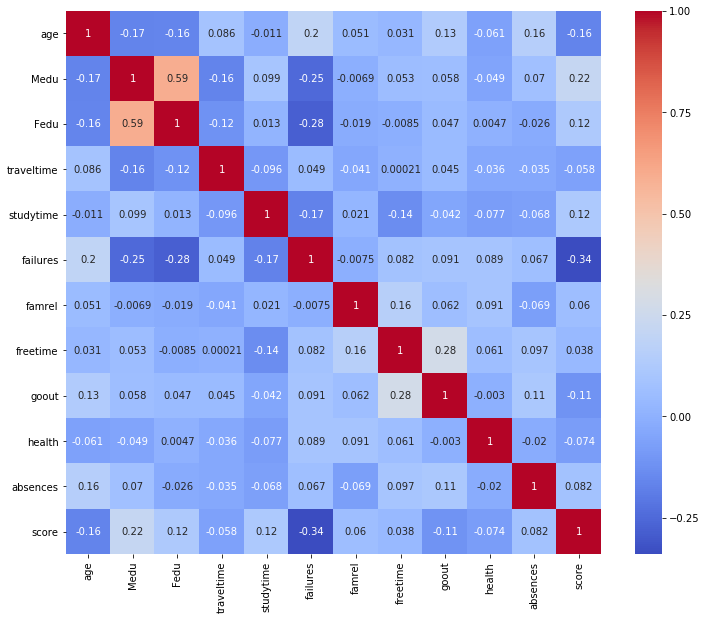

In [88]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

In [89]:
def get_boxplot(data, column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='score', 
                data=data.loc[data.loc[:, column].isin(data.loc[:, column].value_counts().index[:10])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

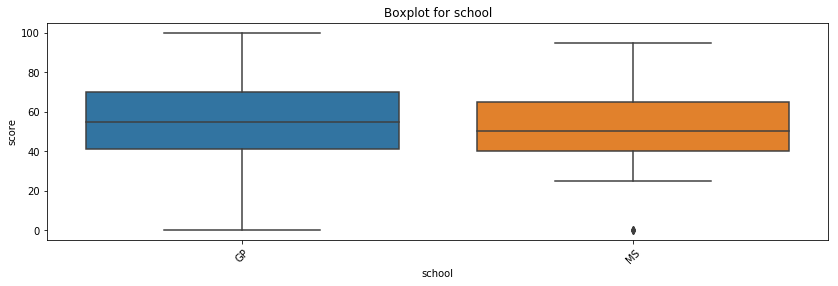

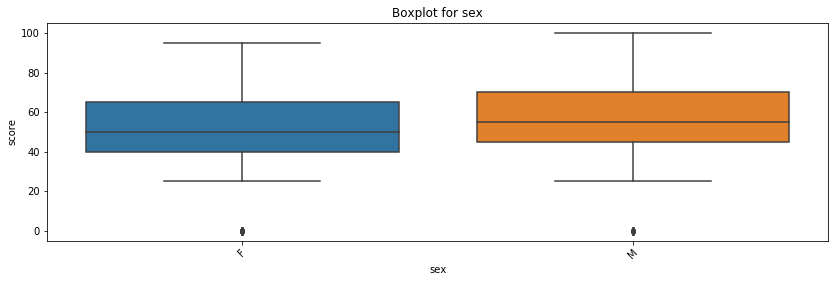

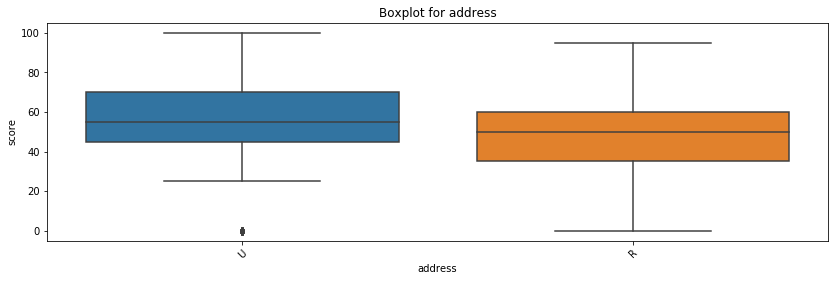

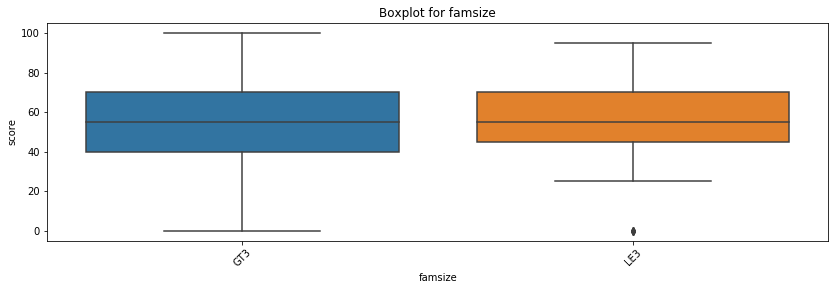

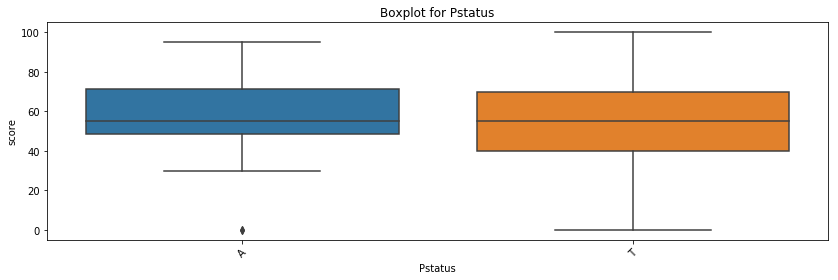

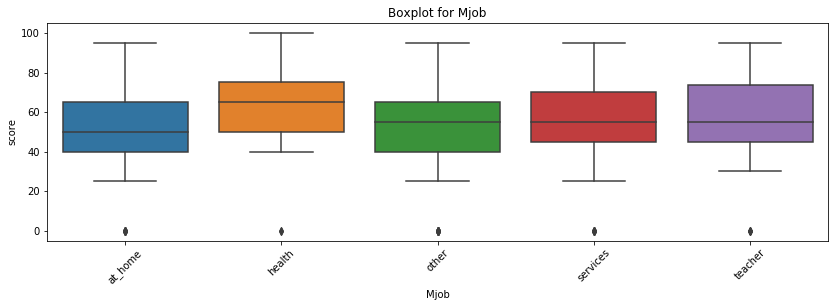

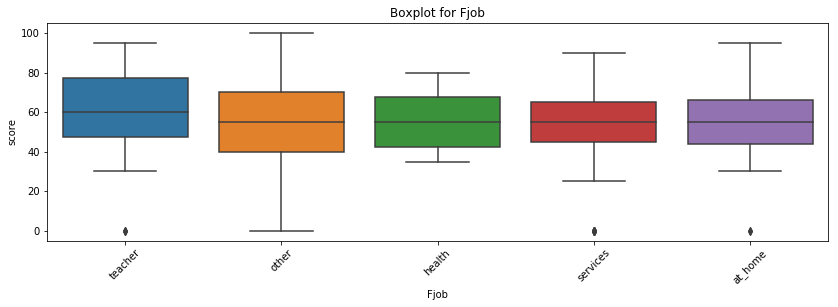

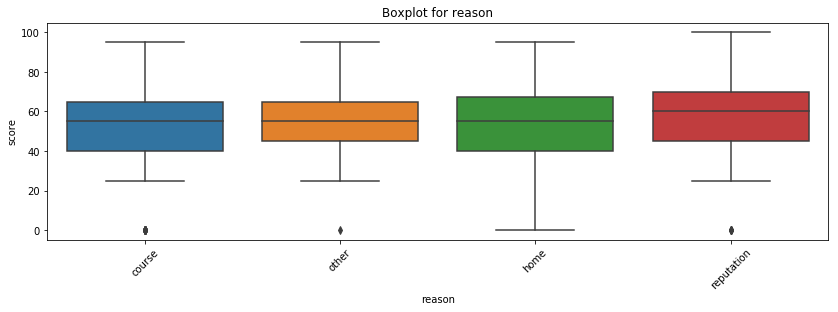

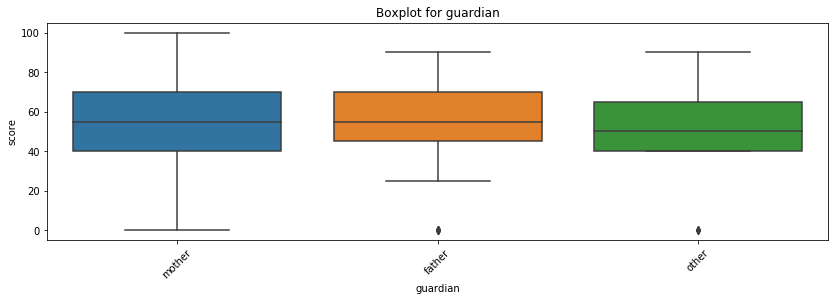

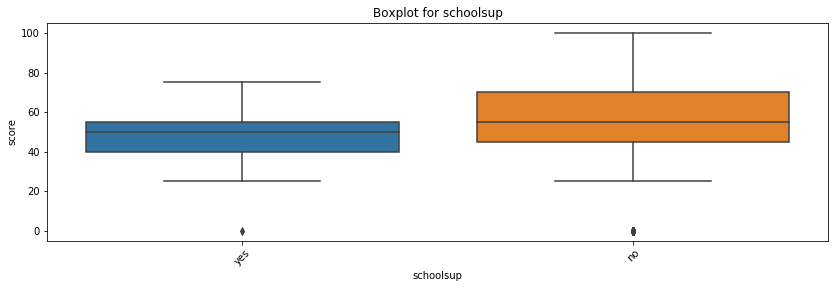

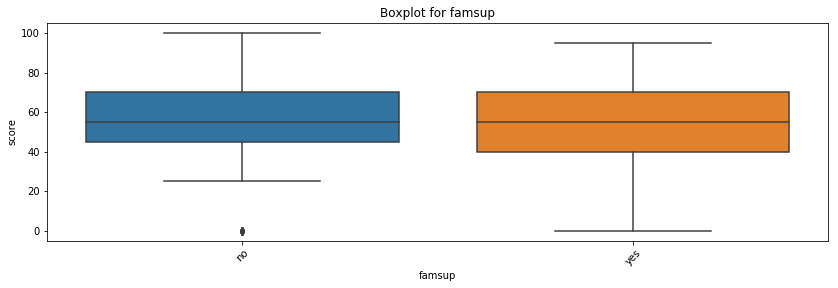

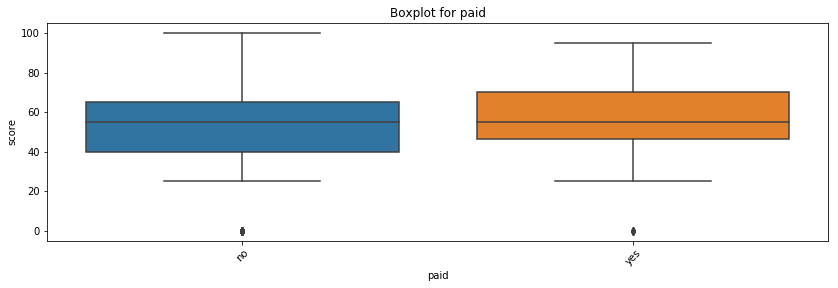

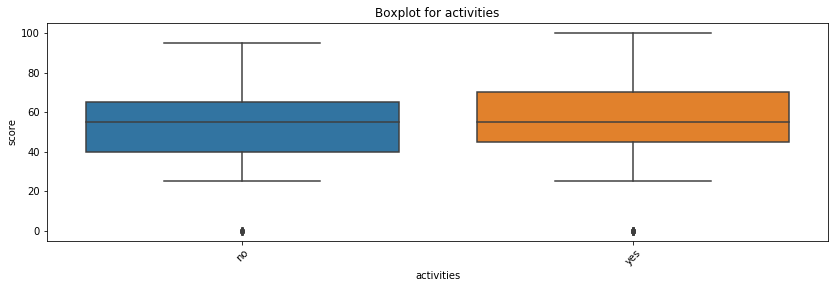

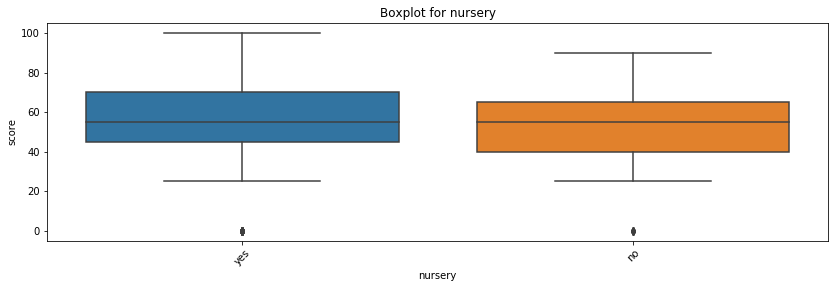

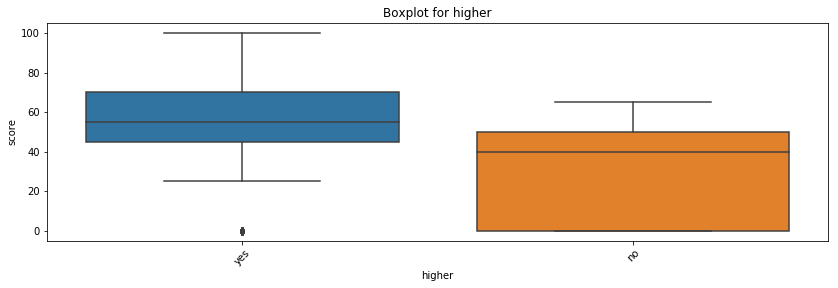

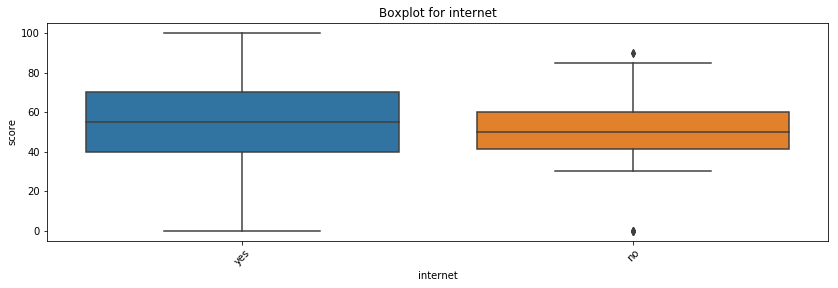

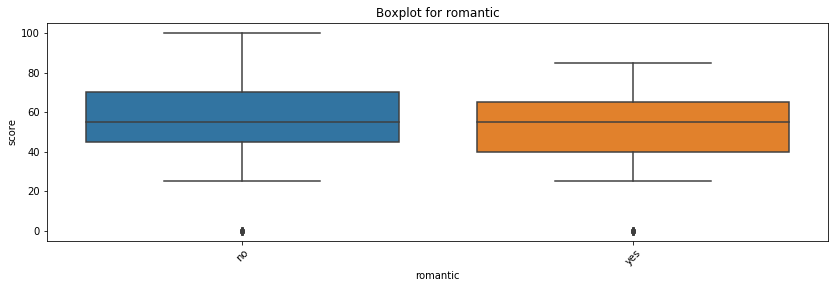

In [90]:
for col in columns_object:
    get_boxplot(students, col)

In [91]:
def get_stat_dif(data, column):
    cols = data.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(data.loc[data.loc[:, column] == comb[0], 'score'], 
                     data.loc[data.loc[:, column] == comb[1], 'score']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [92]:
for col in columns_object:
    get_stat_dif(students, col)

Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки Mjob
Найдены статистически значимые различия для колонки paid
Найдены статистически значимые различия для колонки higher
Найдены статистически значимые различия для колонки romantic
